In [11]:
pip install --upgrade --force-reinstall tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/76/4f/39ddae9fb07b8c039fa5a5f2b6623c6e0564199d82da33fcef62bcf93174/tensorflow-2.16.1-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/14/5a/0e2c734acb91d22fa67ccb7f0cc869e24c418486aaba3d7ca8cad158d5a0/tensorflow_intel-2.16.1-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/bf/45/c961e3cb6ddad76b3

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\nikit\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\~umpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



ModuleNotFoundError: No module named 'tensorflow'

In [5]:
# Load the dataset
df = pd.read_csv("air_pollution_data.csv")

# Preprocessing: Convert 'dt' column to datetime format
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Feature engineering: Extracting features from timestamp
df['hour'] = df['dt'].dt.hour
df['day'] = df['dt'].dt.day
df['month'] = df['dt'].dt.month
df['year'] = df['dt'].dt.year

# Drop the original timestamp column
df.drop('dt', axis=1, inplace=True)





In [6]:
# Splitting the data into features and target variable
X = df.drop('main_aqi', axis=1)
y = df['main_aqi']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

Mean Squared Error: 0.0013695852534562215
R^2 Score: 0.9945206117247238


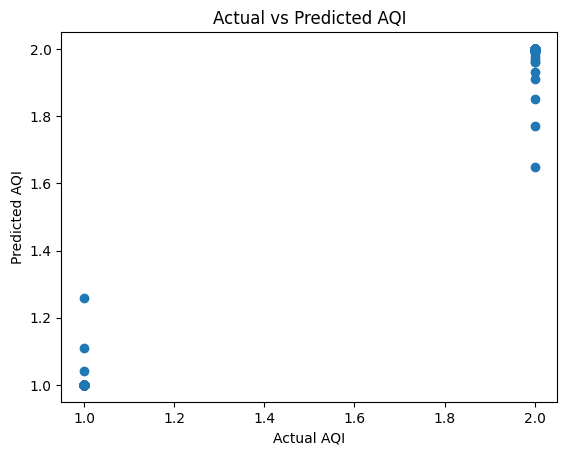

In [7]:
# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Plotting actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI")
plt.show()